In [1]:
from modelos import comunio_pred_lib
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor as LGBR
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

2022-04-29 09:57:42.387823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 09:57:42.387867: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

def create_data_train(journey):
    
    comunio = pd.read_csv(f'../data/pruebas/comunio_J{journey}.csv')

    comunio = comunio.drop(['Matchs', 'Goals', 'Assists','Total_Points' ], axis=1)
    comunio = comunio.rename(columns={f'J_{journey -4}': '-4',
                                          f'J_{journey -3}': '-3',
                                          f'J_{journey -2}': '-2',
                                          f'J_{journey -1}': '-1',
                                          f'J_{journey}': 'Actual'})
    clas = pd.read_excel(f'../data/classification_J_{journey}.xlsx', 
                                     sheet_name=f'classification_J_{journey}', index_col='Unnamed: 0')
    cal = pd.read_csv('../data/pruebas/Season_21-22.csv')
    teams_dict = {'Athletic Club': 'Athletic Club' ,
                            'CA Osasuna':'Osasuna',
                            'Club Atlético de Madrid':'Atlético Madrid',
                            'Cádiz CF':'Cádiz',
                            'Deportivo Alavés':'Alavés',
                            'Elche CF':'Elche',
                            'FC Barcelona':'Barcelona',
                            'Getafe CF':'Getafe',
                            'Granada CF':'Granada',
                            'Levante UD':'Levante',
                            'RC Celta de Vigo':'Celta Vigo',
                            'RCD Espanyol de Barcelona':'Espanyol',
                            'RCD Mallorca':'Mallorca',
                            'Rayo Vallecano de Madrid':'Rayo Vallecano',
                            'Real Betis Balompié':'Betis',
                            'Real Madrid CF':'Real Madrid',
                            'Real Sociedad de Fútbol':'Real Sociedad',
                            'Sevilla FC':'Sevilla',
                            'Valencia CF':'Valencia',
                            'Villarreal CF':'Villarreal'}

    new_team_name = []
    for team in comunio.Team:

        for k,v in teams_dict.items():

            if k == team:

                new_team_name.append(v)

    comunio['Team'] = new_team_name

    points_per_team = comunio.groupby('Team').sum().reset_index()
    points_per_team= points_per_team.rename(columns={
                                                                'Points_Average': 'Squad_Average_Points',
                                                                'Avg_last_5_games': 'Squad_Avg_last_5_Games',
                                                                'Value': 'Value_Squad',
                                                                f'-4': '-4_Squad_Points',
                                                                f'-3': '-3_Squad_Points',
                                                                f'-2': '-2_Squad_Points',
                                                                f'-1': '-1_Squad_Points',
                                                                f'Actual': 'Actual_Squad_Points'})

    points_per_team = points_per_team.drop(['Team_id','On_start_%'], axis=1)

    df_1 = comunio.merge(points_per_team, how='left', left_on='Team', right_on='Team')

    matches_J = cal.loc[cal['Journey'] == (journey+1)]
    matches_J

    vs = []
    for team in df_1.Team:

        for index in matches_J.index:

            if team == matches_J.loc[index].Home:

                vs.append(matches_J.loc[index].Away)

            if team == matches_J.loc[index].Away:

                vs.append(matches_J.loc[index].Home)

    df_1['vs'] = vs

    points_per_vs_team = comunio.groupby('Team').sum().reset_index()
    points_per_vs_team= points_per_vs_team.rename(columns={
                                                                    'Team':'Vs_Team',
                                                                    'Points_Average': 'Vs_Squad_Average_Points',
                                                                    'Avg_last_5_games': 'Vs_Squad_Avg_last_5_Games',
                                                                    'Value':'Vs_Value_Squad',
                                                                    f'-4': '-4_Vs_Squad_Points',
                                                                    f'-3': '-3_Vs_Squad_Points',
                                                                    f'-2': '-2_Vs_Squad_Points',
                                                                    f'-1': '-1_Vs_Squad_Points',
                                                                    f'Actual': 'Actual_Vs_Squad_Points'})

    points_per_vs_team = points_per_vs_team.drop(['Team_id','On_start_%'], axis=1)

    df_2 = df_1.merge(points_per_vs_team, how='left', left_on='vs', right_on='Vs_Team')

    team_clas = []

    for team in comunio.Team:
        for index in clas.index:

            if team in clas.loc[index].Team:

                team_clas.append(clas.loc[index].Position)

    team_clas_vs = []

    for team in df_2.Vs_Team:
        for index in clas.index:

            if team in clas.loc[index].Team:

                team_clas_vs.append(clas.loc[index].Position)

    df_2['Team_clas'] = team_clas
    df_2['Vs_Team_clas'] = team_clas_vs
        
    df_2 = df_2.drop('Team_id', axis=1)
        
       
    return df_2
    
    
        

 

In [3]:
j = [19,20,21,23,25,26,27,28,29,30,31,32]

df = pd.DataFrame()
for journey in j:
    if journey != 21 and journey != 23:
        print('Jornada Actual',journey)
        df_2 = create_data_train(journey)

        n_j = journey+1
        print('Siguiente jornada',n_j)
        next_j = create_data_train(n_j)
        next_j = next_j[['Player','Actual']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', 'Actual':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()
            
        
    
    else:
        print('Jornada Actual 21 o 23',journey)
        df_2 = create_data_train(journey)
        n_j = journey+2
        print('Siguiente jornada +2',n_j)
        next_j = create_data_train(n_j)
        next_j = next_j[['Player','-1']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', '-1':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()

    df = df.append(df_3)

Jornada Actual 19
Siguiente jornada 20
Jornada Actual 20
Siguiente jornada 21
Jornada Actual 21 o 23 21
Siguiente jornada +2 23
Jornada Actual 21 o 23 23
Siguiente jornada +2 25
Jornada Actual 25
Siguiente jornada 26
Jornada Actual 26
Siguiente jornada 27
Jornada Actual 27
Siguiente jornada 28
Jornada Actual 28
Siguiente jornada 29
Jornada Actual 29
Siguiente jornada 30
Jornada Actual 30
Siguiente jornada 31
Jornada Actual 31
Siguiente jornada 32
Jornada Actual 32
Siguiente jornada 33


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6383 entries, 0 to 580
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Team                       6383 non-null   object 
 1   Player                     6383 non-null   object 
 2   Position                   6383 non-null   object 
 3   On_start_%                 6383 non-null   int64  
 4   Points_Average             6383 non-null   float64
 5   Last_5_games_points        6383 non-null   object 
 6   -4                         6383 non-null   int64  
 7   -3                         6383 non-null   int64  
 8   -2                         6383 non-null   int64  
 9   -1                         6383 non-null   int64  
 10  Actual                     6383 non-null   int64  
 11  Avg_last_5_games           6383 non-null   float64
 12  Value                      6383 non-null   int64  
 13  Squad_Average_Points       6383 non-null   float6

In [5]:
df.loc[df['Team']=='Mallorca']

,Team,Player,Position,On_start_%,Points_Average,Last_5_games_points,-4,-3,-2,-1,Actual,Avg_last_5_games,Value,Squad_Average_Points,-4_Squad_Points,-3_Squad_Points,-2_Squad_Points,-1_Squad_Points,Actual_Squad_Points,Squad_Avg_last_5_Games,Value_Squad,vs,Vs_Team,Vs_Squad_Average_Points,-4_Vs_Squad_Points,-3_Vs_Squad_Points,-2_Vs_Squad_Points,-1_Vs_Squad_Points,Actual_Vs_Squad_Points,Vs_Squad_Avg_last_5_Games,Vs_Value_Squad,Team_clas,Vs_Team_clas,Jugador,Target
238,Mallorca,Reina,PT,95,3.8,"['6', '11', '-2', '-', '3']",6,11,-2,0,3,3.6,2640000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Reina,0.0
239,Mallorca,Greif,PT,5,0.0,"['-', '-', '-', '-', '-']",0,0,0,0,0,0.0,330000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Greif,0.0
240,Mallorca,Maffeo,DF,89,4.8,"['2', '4', '2', '-', '1']",2,4,2,0,1,1.8,4210000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Maffeo,4.0
241,Mallorca,Martin Valjent,DF,100,3.4,"['2', '3', '1', '-', '2']",2,3,1,0,2,1.6,2190000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Martin Valjent,0.0
242,Mallorca,Franco Russo,DF,68,4.4,"['13', '3', '-', '-', '2']",13,3,0,0,2,3.6,1410000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Franco Russo,1.0
243,Mallorca,Brian Oliván,DF,63,3.4,"['-', '-', '1', '-', '-']",0,0,1,0,0,0.2,1770000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Brian Oliván,0.0
244,Mallorca,Jaume Costa,DF,47,2.9,"['7', '8', '7', '-', '2']",7,8,7,0,2,4.8,1560000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Jaume Costa,6.0
245,Mallorca,Sedlar,DF,11,1.3,"['2', '-', '2', '-', '-']",2,0,2,0,0,0.8,340000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Sedlar,3.0
247,Mallorca,Dani Rodríguez,MD,95,4.7,"['2', '4', '9', '-', '9']",2,4,9,0,9,4.8,4350000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Dani Rodríguez,0.0
248,Mallorca,Idrissu Baba,MD,79,4.7,"['3', '-', '2', '-', '2']",3,0,2,0,2,1.4,4850000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Idrissu Baba,0.0


In [3]:
def once_ideal_xbgr(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('xgb', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('xgb', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('xgb', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('xgb', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad
def once_ideal_rf(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('rfr', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('rfr', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('rfr', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('rfr', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad
def once_ideal_gb(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('gb', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('gb', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('gb', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('gb', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad
def once_ideal_rnn(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('rnn', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('rnn', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('rnn', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('rnn', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad

In [4]:
def preprocess_data(df):
    
    X = df.drop(['Target'], axis=1)._get_numeric_data()
    y = df.Target
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
    
    X_train_s = x_scaler.fit_transform(X_train)
    X_test_s = x_scaler.transform(X_test)
    
    y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_s = y_scaler.transform(y_test.values.reshape(-1,1))
                    
    return X, y, X_train, X_test, y_train, y_test ,X_train_s, X_test_s, y_train_s, y_test_s, x_scaler, y_scaler

In [10]:
X, y, X_train, X_test, y_train, y_test ,X_train_s, X_test_s, y_train_s, y_test_s, x_scaler, y_scaler = preprocess_data(df)

In [11]:
X.shape, y.shape

((6383, 27), (6383,))

In [12]:
rfr = RandomForestRegressor(max_depth= 5, max_leaf_nodes= 35, n_estimators= 300, n_jobs= -1)
xgbr = XGBRegressor(max_depth=5, n_estimators=500,learning_rate=0.01, n_jobs=-1, gamma=0.1 )
gb = GradientBoostingRegressor(max_depth=5, n_estimators=400,learning_rate=0.001, alpha=0.8, max_leaf_nodes=35)
models = (rfr,xgbr,gb)

In [13]:
for model in models:
    name = str(model)[:13]
  
    model.fit(X_train_s,y_train)
    model.score(X_train_s, y_train)
    pred = model.predict(X_test_s)
    #pred2 = y_scaler.inverse_transform(pred.reshape(-1,1))
    mse = mean_squared_error(pred,y_test, squared=False)
    r2 = r2_score(pred, y_test)
    
    print (f'mse del modelo {name} = {mse}')

mse del modelo RandomForestR = 2.690136168812279
mse del modelo XGBRegressor( = 2.699368904734176
mse del modelo GradientBoost = 2.852052364333579


2022-04-28 16:48:31.808061: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-28 16:48:31.808092: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gobuub-ROG-Strix): /proc/driver/nvidia/version does not exist
2022-04-28 16:48:31.808355: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
120/120 [==============================] - 1s 3ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 2/20
120/120 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0065
Epoch 3/20
120/120 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 4/20
120/120 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 5/20
120/120 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 6/20
120/120 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 7/20
120/120 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 8/20
120/120 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/20
120/120 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 10/20
120/120 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0051

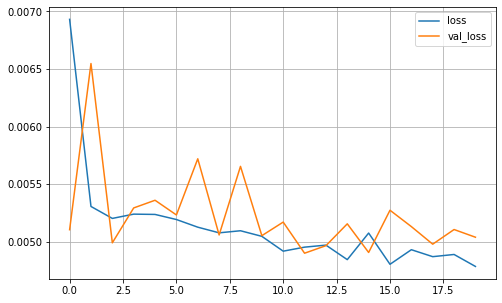

In [14]:
rnn =  Sequential()

rnn.add(Dense(500, activation='relu',input_dim=27))
rnn.add(Dense(250, activation='relu'))
rnn.add(Dense(125, activation='relu'))
rnn.add(Dense(60, activation='relu'))
rnn.add(Dense(1, activation='linear'))

rnn.compile(loss="mean_squared_error",
             optimizer="adam")
his = rnn.fit(X_train_s,
        y_train_s,
        epochs=20,
        validation_split=0.2
        )
pred_rnn = rnn.predict(X_test_s)
pred2_rnn = y_scaler.inverse_transform(pred_rnn)
mse = mean_squared_error(pred2_rnn,y_test, squared=False)
r2 = r2_score(pred2_rnn, y_test)
        
pd.DataFrame(his.history).plot(figsize=(8,5))
plt.grid()
plt.show()

In [22]:
pd.DataFrame(his.history)

,loss,val_loss
0,0.006497,0.005248
1,0.005390,0.005116
2,0.005197,0.004976
3,0.005166,0.005778
4,0.005099,0.005251
5,0.005020,0.005156
6,0.005204,0.004902
7,0.004872,0.004951
8,0.004944,0.005579
9,0.005007,0.004962


In [15]:
print (f'mse del modelo rnn = {mse}')
print (f'R2 score del modelo rnn = {r2}')

mse del modelo rnn = 2.750439110253135
R2 score del modelo rnn = -1.8329012713192112


In [16]:
X_scal = x_scaler.transform(X)

In [61]:
rfr.fit(X,y)
xgbr.fit(X,y)
gb.fit(X,y)


GradientBoostingRegressor(alpha=0.8, learning_rate=0.001, max_depth=5,
                          max_leaf_nodes=35, n_estimators=400)

In [5]:
j_33 = create_data_train(33)
pred_data = j_33._get_numeric_data()

In [6]:
j_33.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 578 entries, 0 to 577
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Team                       578 non-null    object 
 1   Player                     578 non-null    object 
 2   Position                   578 non-null    object 
 3   On_start_%                 578 non-null    int64  
 4   Points_Average             578 non-null    float64
 5   Last_5_games_points        578 non-null    object 
 6   -4                         578 non-null    int64  
 7   -3                         578 non-null    int64  
 8   -2                         578 non-null    int64  
 9   -1                         578 non-null    int64  
 10  Actual                     578 non-null    int64  
 11  Avg_last_5_games           578 non-null    float64
 12  Value                      578 non-null    int64  
 13  Squad_Average_Points       578 non-null    float64

In [19]:
rnn2 = keras.models.load_model('comunio_rnn.h5')

In [62]:
pred_rfr = rfr.predict(pred_data)
pred_xgb = xgbr.predict(pred_data)
pred_gb = gb.predict(pred_data)
pred_rnn = y_scaler.inverse_transform(rnn.predict(x_scaler.transform(pred_data)))
pred_rnn2 = y_scaler.inverse_transform(rnn2.predict(x_scaler.transform(pred_data)))

In [63]:
preds = pd.DataFrame(j_33['Player'])
preds['Position'] = j_33.Position
preds['rfr'] = pred_rfr
preds['xgb'] = pred_xgb
preds['gb'] = pred_gb
preds['rnn'] = pred_rnn
preds['rnn2'] = pred_rnn2
preds = round(preds)

preds

,Player,Position,rfr,xgb,gb,rnn,rnn2
0,Unai Simón,PT,3.0,3.0,2.0,3.0,2.0
1,Agirrezabala,PT,1.0,1.0,2.0,1.0,1.0
2,Ezkieta,PT,0.0,0.0,2.0,0.0,0.0
3,Iñigo Martínez,DF,2.0,1.0,2.0,2.0,2.0
4,Daniel Vivian,DF,3.0,2.0,2.0,2.0,2.0
5,De Marcos,DF,3.0,2.0,2.0,2.0,2.0
6,Yeray Álvarez,DF,3.0,2.0,2.0,2.0,2.0
7,Lekue,DF,2.0,2.0,2.0,2.0,1.0
8,Balenziaga,DF,2.0,2.0,2.0,2.0,1.0
9,Yuri Berchiche,DF,3.0,3.0,3.0,2.0,2.0


In [75]:
once_ideal_rf(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2
49,Sergio Herrera,PT,5.0,6.0,3.0,5.0,4.0
108,Jordi Alba,DF,5.0,5.0,3.0,6.0,6.0
347,Le Normand,DF,4.0,4.0,3.0,5.0,5.0
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0
394,Parejo,MD,6.0,6.0,3.0,8.0,7.0
13,Muniain,MD,5.0,5.0,3.0,5.0,5.0
118,Sergio Busquets,MD,5.0,5.0,3.0,6.0,6.0
329,Canales,MD,5.0,5.0,3.0,7.0,7.0
220,Benzema,DL,7.0,8.0,4.0,10.0,8.0
127,Dembélé,DL,6.0,7.0,3.0,8.0,6.0


In [76]:
once_ideal_gb(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2
495,Édgar Badía,PT,4.0,5.0,3.0,5.0,4.0
444,Miazga,DF,2.0,1.0,3.0,1.0,1.0
202,Alaba,DF,4.0,4.0,3.0,5.0,5.0
108,Jordi Alba,DF,5.0,5.0,3.0,6.0,6.0
328,Fekir,MD,5.0,6.0,4.0,7.0,6.0
13,Muniain,MD,5.0,5.0,3.0,5.0,5.0
183,Darwin Machís,MD,4.0,3.0,3.0,4.0,3.0
239,Álvaro García,MD,4.0,5.0,3.0,5.0,4.0
220,Benzema,DL,7.0,8.0,4.0,10.0,8.0
130,Ferrán Torres,DL,5.0,5.0,4.0,6.0,6.0


In [77]:
once_ideal_xbgr(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2
49,Sergio Herrera,PT,5.0,6.0,3.0,5.0,4.0
497,Johan Mojica,DF,4.0,5.0,3.0,5.0,4.0
201,Éder Militão,DF,4.0,5.0,3.0,5.0,5.0
551,Diego Carlos,DF,4.0,5.0,3.0,6.0,5.0
394,Parejo,MD,6.0,6.0,3.0,8.0,7.0
328,Fekir,MD,5.0,6.0,4.0,7.0,6.0
13,Muniain,MD,5.0,5.0,3.0,5.0,5.0
239,Álvaro García,MD,4.0,5.0,3.0,5.0,4.0
220,Benzema,DL,7.0,8.0,4.0,10.0,8.0
127,Dembélé,DL,6.0,7.0,3.0,8.0,6.0


In [78]:
once_ideal_rnn(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2
345,Alex Remiro,PT,4.0,4.0,3.0,5.0,4.0
108,Jordi Alba,DF,5.0,5.0,3.0,6.0,6.0
553,Kounde,DF,4.0,4.0,3.0,6.0,5.0
551,Diego Carlos,DF,4.0,5.0,3.0,6.0,5.0
394,Parejo,MD,6.0,6.0,3.0,8.0,7.0
212,Kroos,MD,5.0,5.0,3.0,7.0,6.0
397,Danjuma,MD,5.0,5.0,3.0,7.0,6.0
559,Rakitic,MD,4.0,4.0,3.0,7.0,6.0
220,Benzema,DL,7.0,8.0,4.0,10.0,8.0
405,Gerard Moreno,DL,5.0,4.0,3.0,8.0,6.0


In [79]:
squad = ['Courtois', 'Bono',
         'Balliu', 
         'Fran García',
         'Maffeo',
         #'Ronald Araujo', 
         'Alderete', 'Manu Sánchez', 
         #'Giménez',
         'Yéremi',  'Gavi',  
         #'Modric',  
         'Brais', 'Papu Gómez', 'Dani Rodríguez', 'Pere Milla', 'Cervi', 'Berenguer',
         'Vinícius Júnior', 'Aubameyang', 
         #'Sancet',  
         'Morales']
df_squad_kike = pd.DataFrame()
for player in squad:
    #print (player)
    for p in preds.Player:
        if player in p:
            #print('encontrado')
            add_player = pd.DataFrame(preds.loc[preds.Player==p])
            #print(add_player)
            df_squad_kike = df_squad_kike.append(add_player)
print(len(squad),len(df_squad_kike))

df_squad_kike.at[517,'Position'] = 'MD'
df_squad_kike = round(df_squad_kike)
df_squad_kike


18 18


,Player,Position,rfr,xgb,gb,rnn,rnn2
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0
548,Bono,PT,3.0,3.0,3.0,5.0,4.0
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
290,Maffeo,DF,3.0,3.0,2.0,2.0,2.0
412,Omar Alderete,DF,3.0,3.0,3.0,4.0,3.0
53,Manu Sánchez,DF,3.0,3.0,2.0,4.0,3.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0


In [80]:
xgb_eleven = round(once_ideal_xbgr(df_squad_kike,3,4,3))

rf_eleven = round(once_ideal_rf(df_squad_kike,3,4,3))

gb_eleven = round(once_ideal_gb(df_squad_kike,3,4,3))

rnn_eleven = round(once_ideal_rnn(df_squad_kike,3,4,3))

In [81]:
xgb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
290,Maffeo,DF,3.0,3.0,2.0,2.0,2.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
299,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0
128,Aubameyang,DL,5.0,4.0,3.0,7.0,6.0


In [82]:
rf_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
290,Maffeo,DF,3.0,3.0,2.0,2.0,2.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
299,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0
128,Aubameyang,DL,5.0,4.0,3.0,7.0,6.0


In [83]:
gb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0
412,Omar Alderete,DF,3.0,3.0,3.0,4.0,3.0
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
561,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0
128,Aubameyang,DL,5.0,4.0,3.0,7.0,6.0


In [84]:
rnn_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
548,Bono,PT,3.0,3.0,3.0,5.0,4.0
412,Omar Alderete,DF,3.0,3.0,3.0,4.0,3.0
53,Manu Sánchez,DF,3.0,3.0,2.0,4.0,3.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
561,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0
128,Aubameyang,DL,5.0,4.0,3.0,7.0,6.0
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0


In [85]:
print('Totales xgb: ', sum(xgb_eleven.xgb), ', real: ', 
      #sum(xgb_eleven.J_32)
     )
print('Totales rfr: ', sum(rf_eleven.rfr), ', real: ', 
      #sum(rf_eleven.J_32)
     )
print('Totales gb: ', sum(gb_eleven.gb), ', real: ', 
      #sum(gb_eleven.J_32)
     )
print('Totales rnn: ', sum(rnn_eleven.rnn), ', real: ', 
      #sum(gb_eleven.J_32)
     )
print('Totales rnn2: ', sum(rnn_eleven.rnn2), ', real: ', 
      #sum(gb_eleven.J_32)
     )

Totales xgb:  42.0 , real: 
Totales rfr:  44.0 , real: 
Totales gb:  31.0 , real: 
Totales rnn:  52.0 , real: 
Totales rnn2:  45.0 , real: 


In [86]:
xgb_eleven = round(once_ideal_xbgr(df_squad_kike,3,5,2))

rf_eleven = round(once_ideal_rf(df_squad_kike,3,5,2))

gb_eleven = round(once_ideal_gb(df_squad_kike,3,5,2))

rnn_eleven = round(once_ideal_rnn(df_squad_kike,3,5,2))
print('Totales xgb: ', sum(xgb_eleven.xgb), ', real: ', 
      #sum(xgb_eleven.J_32)
     )
print('Totales rfr: ', sum(rf_eleven.rfr), ', real: ', 
      #sum(rf_eleven.J_32)
     )
print('Totales gb: ', sum(gb_eleven.gb), ', real: ', 
      #sum(gb_eleven.J_32)
     )
print('Totales rnn: ', sum(rnn_eleven.rnn), ', real: ', 
      #sum(gb_eleven.J_32)
     )
print('Totales rnn2: ', sum(rnn_eleven.rnn2), ', real: ', 
      #sum(gb_eleven.J_32)
     )

Totales xgb:  42.0 , real: 
Totales rfr:  43.0 , real: 
Totales gb:  31.0 , real: 
Totales rnn:  50.0 , real: 
Totales rnn2:  43.0 , real: 


In [87]:
rf_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
290,Maffeo,DF,3.0,3.0,2.0,2.0,2.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
299,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0
533,Franco Cervi,MD,4.0,4.0,3.0,4.0,3.0
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0


In [88]:
xgb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
290,Maffeo,DF,3.0,3.0,2.0,2.0,2.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
299,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0
533,Franco Cervi,MD,4.0,4.0,3.0,4.0,3.0
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0


In [89]:
gb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0
412,Omar Alderete,DF,3.0,3.0,3.0,4.0,3.0
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
561,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0
299,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0


In [90]:
rnn_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2
548,Bono,PT,3.0,3.0,3.0,5.0,4.0
412,Omar Alderete,DF,3.0,3.0,3.0,4.0,3.0
53,Manu Sánchez,DF,3.0,3.0,2.0,4.0,3.0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0
396,Yéremi Pino,MD,4.0,4.0,3.0,4.0,3.0
531,Brais Méndez,MD,4.0,4.0,3.0,4.0,3.0
561,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0
533,Franco Cervi,MD,4.0,4.0,3.0,4.0,3.0
128,Aubameyang,DL,5.0,4.0,3.0,7.0,6.0


In [57]:
import pickle

In [103]:
pickle.dump(rfr, open( 'comunio_rfr_2.model', 'wb') )
pickle.dump(xgbr, open( 'comunio_xgbr_".model', 'wb') )
pickle.dump(gb, open( 'comunio_gb_2.model', 'wb') )
pickle.dump(rnn, open( 'comunio_rnn_2.model', 'wb') )
pickle.dump(rnn2, open( 'comunio_rnn.model', 'wb') )


2022-04-28 17:15:23.278957: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://a20db902-35fc-4141-b046-04dfa8da65c1/assets
INFO:tensorflow:Assets written to: ram://04baedd3-d8a6-4c2e-8458-90b734b177d0/assets


In [73]:
len(j_33.Actual)

578

In [74]:
len(j_33.Actual[-38:])

38

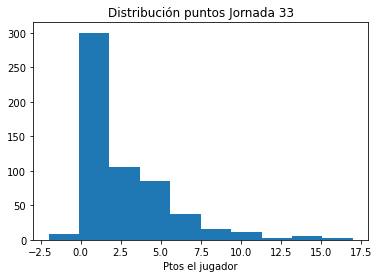

In [91]:
plt.hist(y[-576:], bins=10);
plt.title('Distribución puntos Jornada 33')
plt.xlabel('Ptos el jugador');

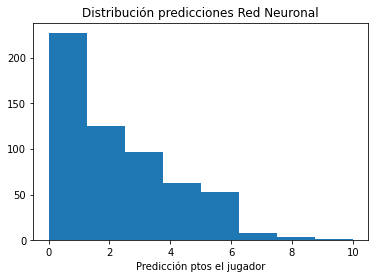

In [92]:
plt.hist(round(preds.rnn), bins=8);
plt.title('Distribución predicciones Red Neuronal')
plt.xlabel('Predicción ptos el jugador');


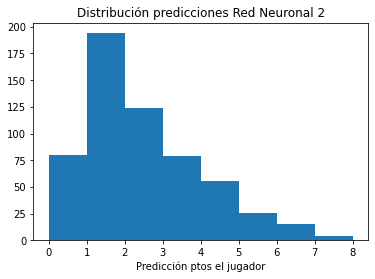

In [93]:
plt.hist(round(preds.rnn2), bins=8);
plt.title('Distribución predicciones Red Neuronal 2')
plt.xlabel('Predicción ptos el jugador');

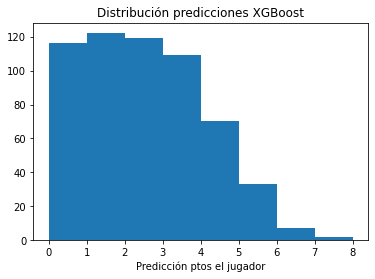

In [94]:
plt.hist(round(preds.xgb), bins=8);
plt.title('Distribución predicciones XGBoost')
plt.xlabel('Predicción ptos el jugador');

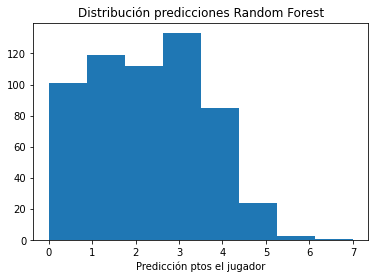

In [95]:
plt.hist(round(preds.rfr), bins=8);
plt.title('Distribución predicciones Random Forest')
plt.xlabel('Predicción ptos el jugador');

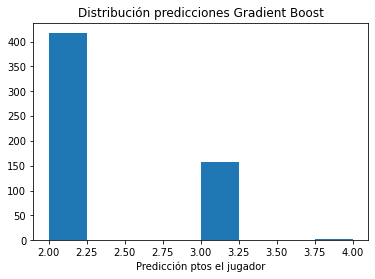

In [96]:
plt.hist(round(preds.gb), bins=8);
plt.title('Distribución predicciones Gradient Boost')
plt.xlabel('Predicción ptos el jugador');

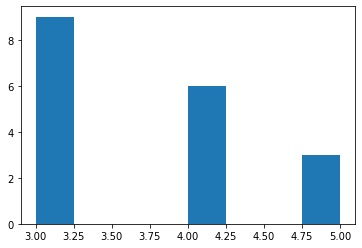

In [97]:
plt.hist(round(df_squad_kike.rfr), bins=8);

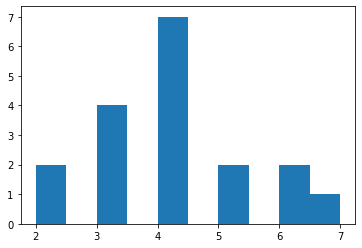

In [98]:
plt.hist(df_squad_kike.rnn);

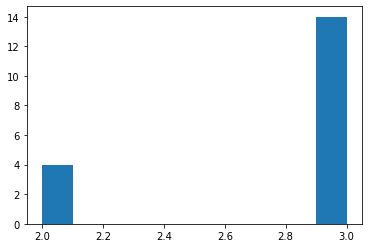

In [99]:
plt.hist(df_squad_kike.gb);

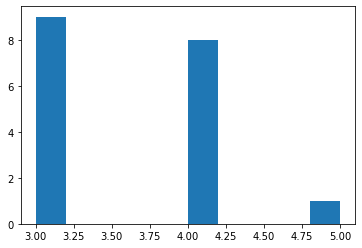

In [100]:
plt.hist(df_squad_kike.xgb);

In [101]:
preds.rnn.value_counts()


1.0     181
2.0     125
3.0      97
4.0      63
0.0      46
5.0      38
6.0      15
7.0       8
8.0       4
10.0      1
Name: rnn, dtype: int64

In [102]:
preds.rnn2.value_counts()

1.0    194
2.0    124
0.0     80
3.0     79
4.0     56
5.0     26
6.0     15
7.0      3
8.0      1
Name: rnn2, dtype: int64

In [58]:
preds.xgb.value_counts()

5.0    194
6.0    149
3.0    106
7.0     78
4.0     28
2.0     23
Name: xgb, dtype: int64

In [59]:
preds.gb.value_counts()

3.0    328
2.0    138
4.0    112
Name: gb, dtype: int64

In [60]:
preds.rfr.value_counts()

8.0    237
5.0    140
9.0    125
7.0     76
Name: rfr, dtype: int64

In [6]:
j_33.to_csv('comunio_data_j_33.csv', index=False)
